# Zillow prize data analysis report

In [1]:
from datetime import datetime
d = datetime.now().date()
t = datetime.now().strftime('%H:%M:%S')
print("This report was last updated on", d, "at", t)

This report was last updated on 2017-10-12 at 11:52:31


## Introduction

The [Zillow Prize](https://www.zillow.com/promo/Zillow-prize/) is a [Kaggle competition](https://www.kaggle.com/c/zillow-prize-1) that aims to inspire data scientists around the world to improve the accuracy of the Zillow "Zestimate" statistical and machine learning models. 

My goal is to compete for the Zillow prize and write up my results.

## Methods

### Data

The data were obtained from [Kaggle website](https://www.kaggle.com/c/zillow-prize-1/data) and consist of the following files:
- `properties_2016.csv.zip`
- `properties_2017.csv.zip`
- `sample_submission.csv`
- `train_2016_v2.csv.zip`
- `train_2017.csv.zip`
- `zillow_data_dictionary.xlsx` 
The `zillow_data_dictionary.xlsx` is a code book that explains the data.
This data will be made available on [figshare](https://figshare.com/) to provide an additional source if the [Kaggle site data](https://www.kaggle.com/c/zillow-prize-1/data) become unavailable.

### Analysis

Data analysis was done in Jupyter Notebook (Pérez and Granger 2007)<cite data-cite="5251998/SH25XT8L"></cite> Integrated Development Environment using the Python language (Pérez, Granger, and Hunter 2011)<cite data-cite="5251998/FGTD82L2"></cite> and a number of software packages:

- NumPy (van der Walt, Colbert, and Varoquaux 2011)<cite data-cite="5251998/3SWILWGR"></cite>

- pandas (McKinney 2010)<cite data-cite="5251998/K3NZPGU9"></cite>

- scikit-learn (Pedregosa et al. 2011)<cite data-cite="5251998/SBYLEUVD"></cite>


### Visualization

The following packages were used to visualize the data:

- Matplotlib (Hunter 2007)<cite data-cite="5251998/WP5LZ6AZ"></cite>

- Seaborn (Waskom et al. 2014)<cite data-cite="5251998/NSFX6VMN"></cite>

- r-ggplot2

- r-cowplot

The use of `R` code and packages in a `Python` environment is possible through the use of the `Rpy2` package.

### Prediction

Machine learning prediction was done using the following packages:

- scikit-learn (Pedregosa et al. 2011)<cite data-cite="5251998/SBYLEUVD"></cite>
- xgboost
- r-caret 

### Reproducibility

Reproducibility is extremely important in scientific research yet many examples of problematic studies exist in the literature (Couzin-Frankel 2010)<cite data-cite="5251998/UXR4ZTUS"></cite>.

The names and versions of each package used herein are listed in the accompanying `env.yml` file in the `config` folder.
The computational environment used to analyze the data can be recreated using this `env.yml` file and the [`conda` package and environment manager](https://conda.io/docs/using/envs.html) available as part of the [Anaconda distribution of Python](https://www.anaconda.com/download/).

Additionally, details on how to setup a Docker image capable of running the analysis is included in the `README.md` file in the `config` folder.

The code in the form of a jupyter notebook (`01_zillow_MWS.ipynb`) or Python script (`01_zillow_MWS.py`), can also be run on the Kaggle website (this requires logging in with a username and password).

More information on the details of how this project was created and the computational environment was configured can be found in the accompanying `README.md` file.

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python (a modified version of this docker image will be made available as part of my project to ensure reproducibility).
For example, here's several helpful packages to load in 

## Results

### Import Libraries and Data

Input data files are available in the "../input/" directory.

Any results I write to the current directory are saved as output.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [26]:
# Set plot parameters
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"
%matplotlib inline
### Seaborn style
sns.set_style("whitegrid")

In [25]:
prop = pd.read_csv("../input/properties_2016.csv", low_memory=False)
prop.shape

(2985217, 58)

In [44]:
### ... check for NaNs
nan = prop.isnull().sum()/len(prop)*100

In [50]:
### Plotting NaN counts
nan_sorted = nan.sort_values(ascending=False).to_frame().reset_index()
nan_sorted.columns = ['Column', 'percentNaN']

In [51]:
nan_sorted.head()

Column  percentNaN
0               storytypeid   99.945599
1              basementsqft   99.945465
2        yardbuildingsqft26   99.911330
3             fireplaceflag   99.827048
4  architecturalstyletypeid   99.796966

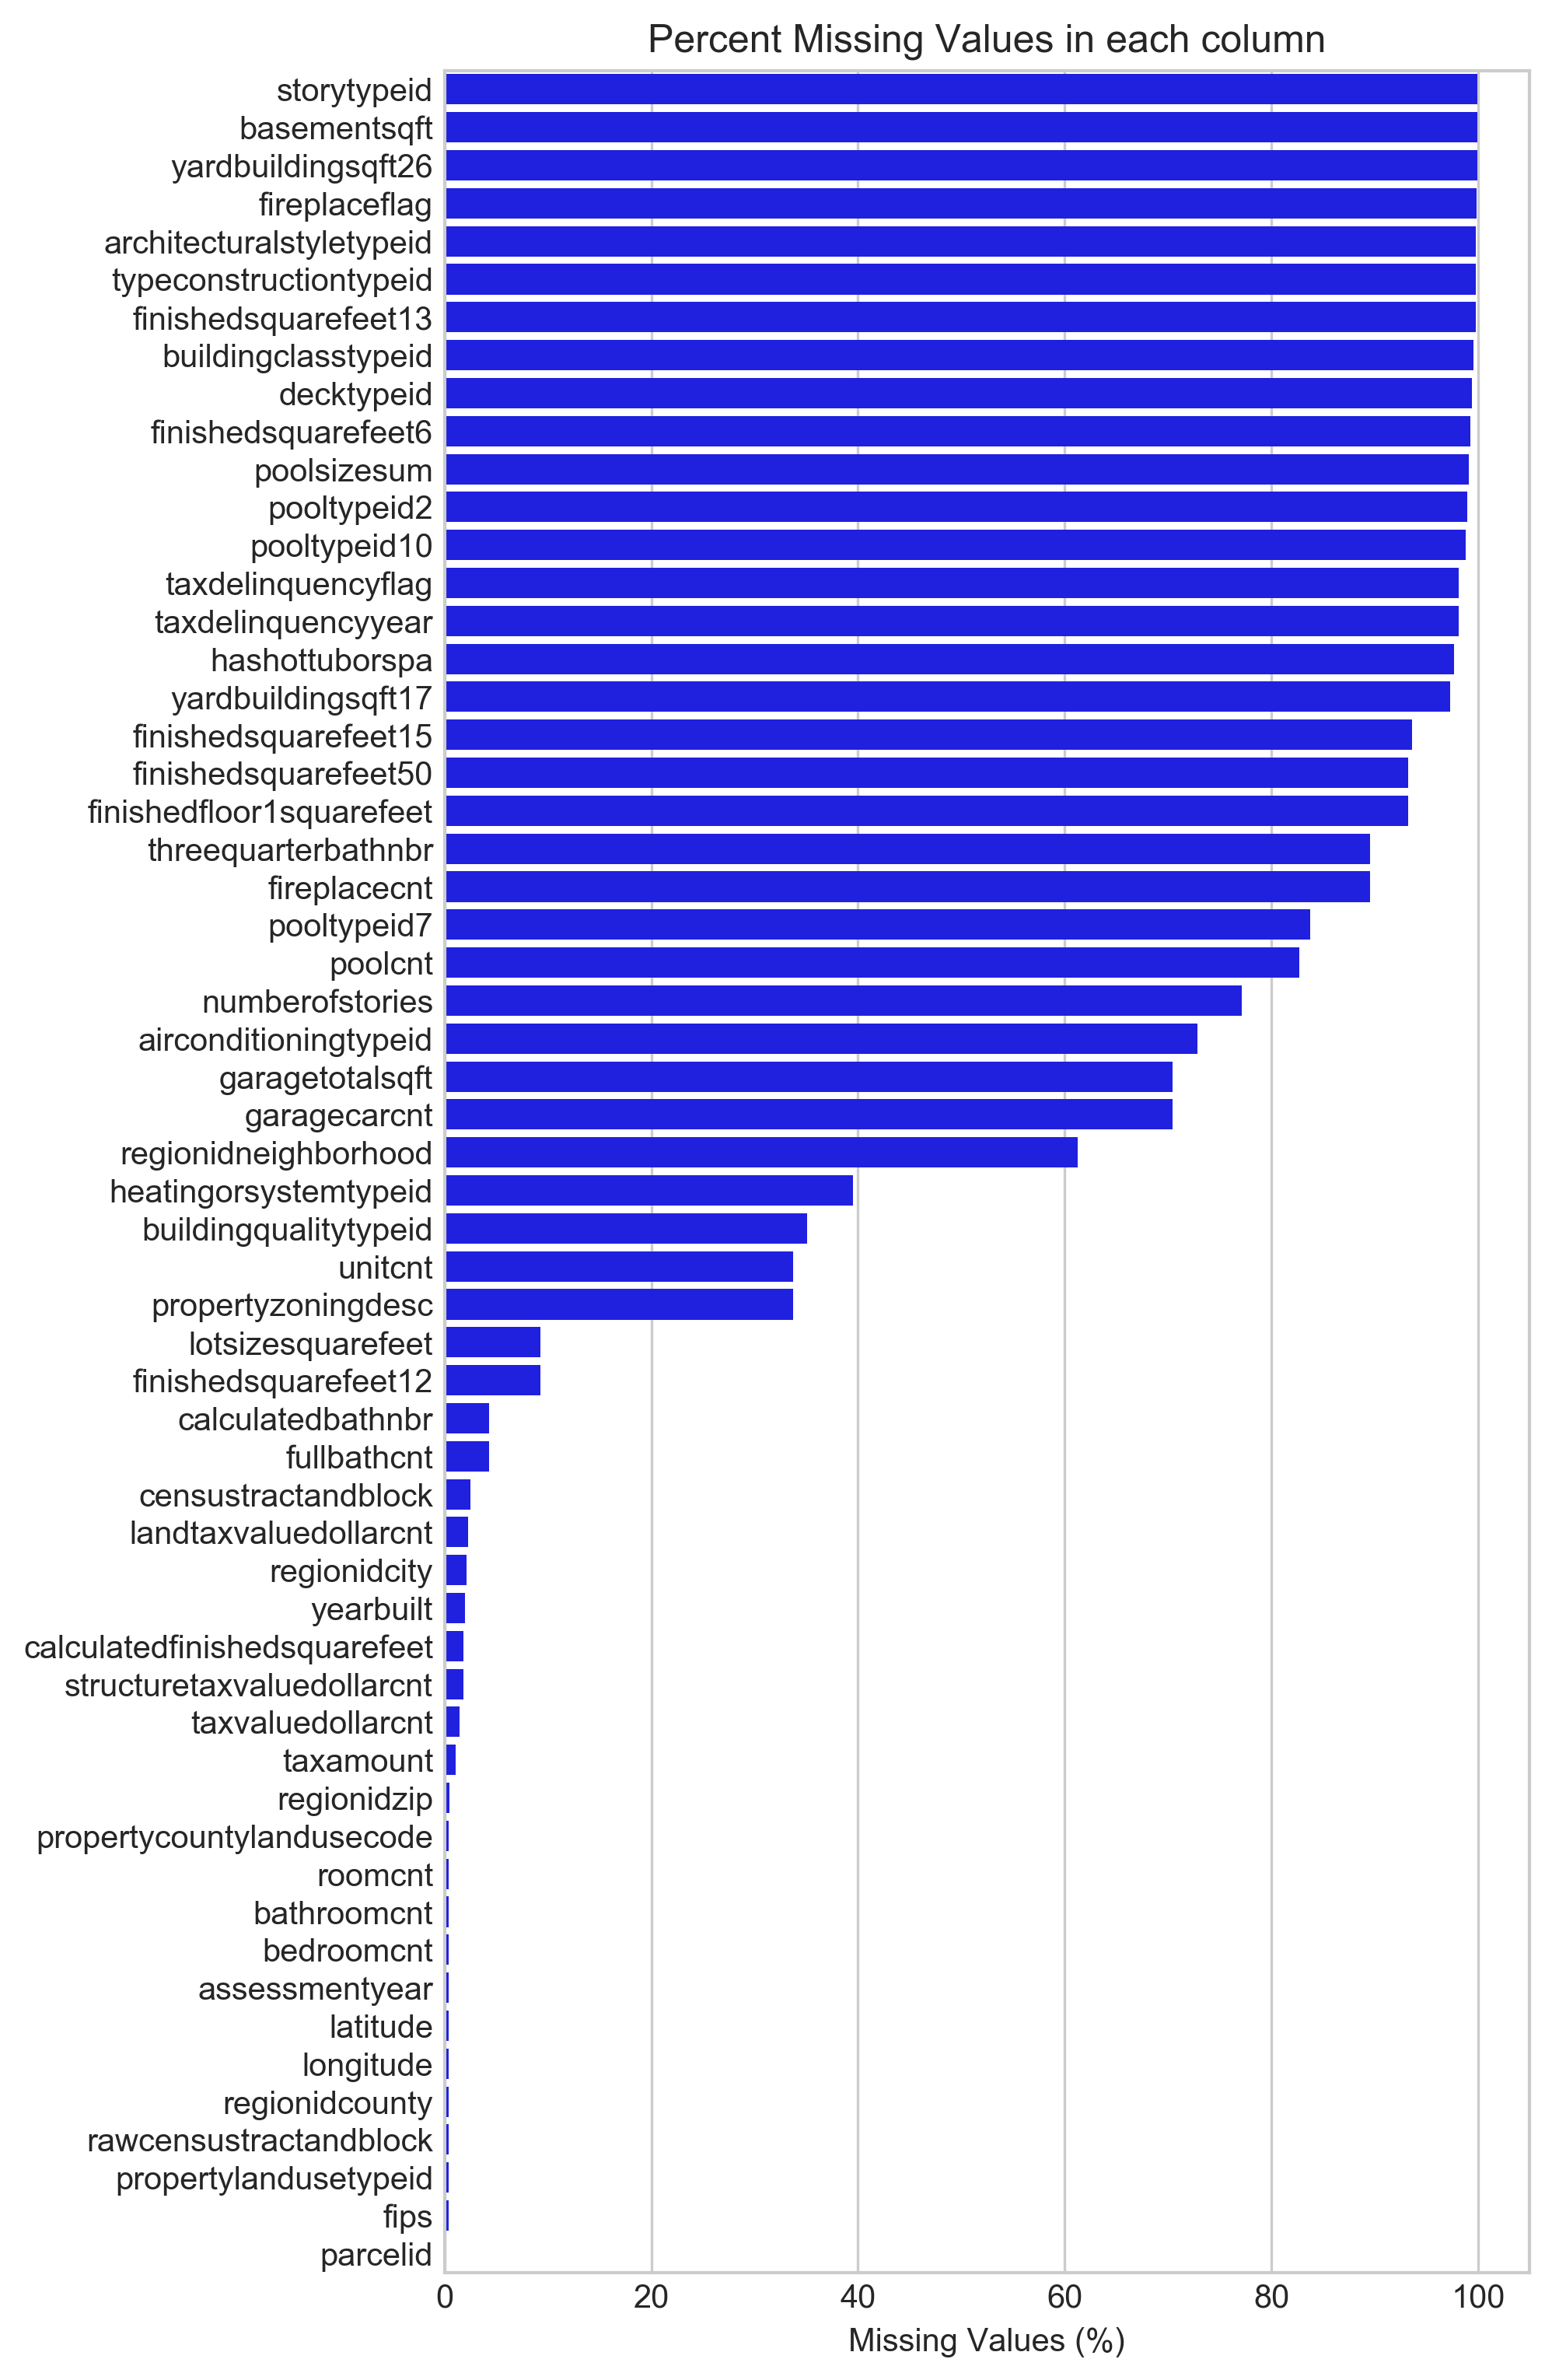

In [52]:
fig, ax = plt.subplots(figsize=(6, 12.5), dpi=300)
sns.barplot(x="percentNaN", y="Column", data=nan_sorted, color='Blue', ax=ax)
ax.set(xlabel="Missing Values (%)", ylabel="", title="Percent Missing Values in each column")
plt.show()

There are several columns which have a very high proportion of missing values. I will remove features that have more than 80% missing values.

#### Feature Importance by Random Forest

In [7]:
train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train.shape

(90275, 3)

In [8]:
train['transaction_month'] = pd.DatetimeIndex(train['transactiondate']).month
train.sort_values('transaction_month', axis=0, ascending=True, inplace=True)


Feature Importance

In [9]:
#fill NaN values with -1 and encode object columns 
for x in prop.columns:
    prop[x] = prop[x].fillna(-1)

#many more parcelids in properties file, merge with training file
train = pd.merge(train, prop, on='parcelid', how='left')


In [10]:
for c in train[['transactiondate', 'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']]:
    label = LabelEncoder()
    label.fit(list(train[c].values))
    train[c] = label.transform(list(train[c].values))

x_train = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = train['logerror']

In [11]:
rf = RandomForestRegressor(n_estimators=30, max_features=None)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:
rf_importance = rf.feature_importances_
rf_importance_df = pd.DataFrame()
rf_importance_df['features'] = x_train.columns
rf_importance_df['importance'] = rf_importance
print(rf_importance_df.head())

                   features  importance
0         transaction_month    0.041078
1     airconditioningtypeid    0.005809
2  architecturalstyletypeid    0.000262
3              basementsqft    0.000238
4               bathroomcnt    0.007725


In [13]:
rf_importance_df.sort_values('importance', axis=0, inplace=True, ascending=False)

print(rf_importance_df.head())

                      features  importance
50  structuretaxvaluedollarcnt    0.084278
24                    latitude    0.078829
54                   taxamount    0.076839
25                   longitude    0.072749
26           lotsizesquarefeet    0.071840


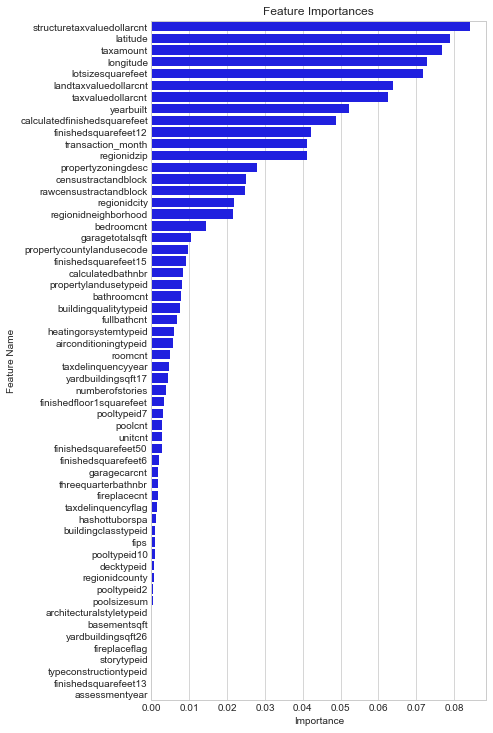

In [14]:
fig, ax = plt.subplots(figsize=(6, 12.5))
sns.barplot(x="importance", y="features", data=rf_importance_df, color='Blue', ax=ax)
ax.set(xlabel="Importance", ylabel="Feature Name", title="Feature Importances")
plt.show()

In [32]:
etr = ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
etr.fit(x_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=30,
          max_features=0.3, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
etr_importance = etr.feature_importances_
etr_importance_df = pd.DataFrame()
etr_importance_df['features'] = x_train.columns
etr_importance_df['importance'] = etr_importance
print(etr_importance_df.head())

                   features  importance
0         transaction_month    0.052949
1     airconditioningtypeid    0.015291
2  architecturalstyletypeid    0.000204
3              basementsqft    0.000212
4               bathroomcnt    0.014486


In [17]:
etr_importance_df.sort_values('importance', axis=0, inplace=True, ascending=False)

print(etr_importance_df.head())

                      features  importance
50  structuretaxvaluedollarcnt    0.060509
54                   taxamount    0.059521
53       landtaxvaluedollarcnt    0.056897
51           taxvaluedollarcnt    0.056176
26           lotsizesquarefeet    0.054112


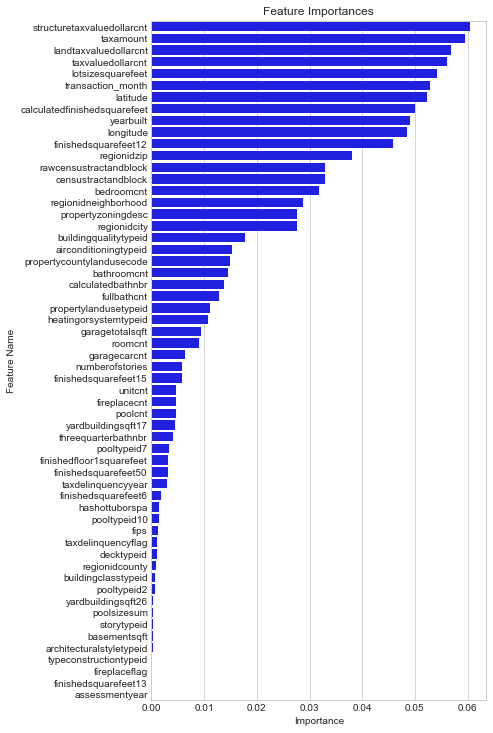

In [18]:
fig, ax = plt.subplots(figsize=(6, 12.5))
sns.barplot(x="importance", y="features", data=etr_importance_df, color='Blue', ax=ax)
ax.set(xlabel="Importance", ylabel="Feature Name", title="Feature Importances")
plt.show()

In [19]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(x_train, y_train, feature_names=x_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

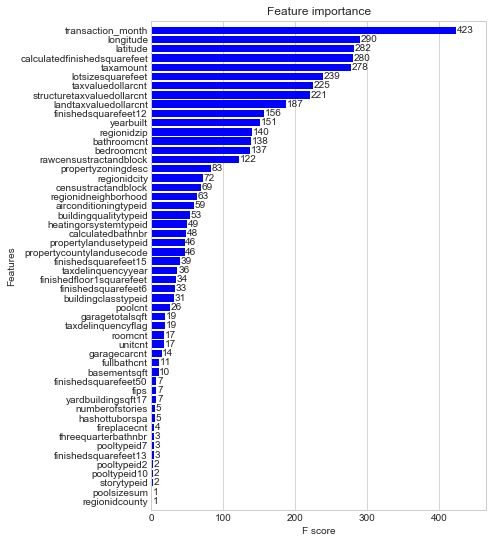

In [20]:
# plot the important features #
fig, ax = plt.subplots(figsize=(6,9))
xgb.plot_importance(model, height=0.8, grid = False, color="blue", ax=ax)
ax.xaxis.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

plt.close('all')

# Just a figure and one subplot
f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

# Four polar axes
f, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'))
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

plt.show()


## Conclusions

In Progress

## Bibliography

Couzin-Frankel, J. 2010. “Cancer Research. As Questions Grow, Duke Halts Trials, Launches Investigation.” Science 329 (5992): 614–15. 

Hunter, J. D. 2007. “Matplotlib: A 2D Graphics Environment.” Computing In Science & Engineering 9 (3): 90–95.

McKinney, W. 2010. “Data Structures for Statistical Computing in Python.” In Proceedings of the 9th Python in Science Conference, edited by S. J. van der Walt and K. J. Millman. Austin, Texas.

Pedregosa, Fabian, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, et al. 2011. “Scikit-Learn: Machine Learning in Python.” Journal of Machine Learning Research 12 (Oct): 2825–30.

Pérez, F., and B. E. Granger. 2007. “IPython: A System for Interactive Scientific Computing.” Computing in Science & Engineering 9 (3): 21–29.

Pérez, F., B. E. Granger, and J. D. Hunter. 2011. “Python: An Ecosystem for Scientific Computing.” Computing in Science & Engineering 13 (2): 13–21.

Van der Walt, S., S. C. Colbert, and G. Varoquaux. 2011. “The NumPy Array: A Structure for Efficient Numerical Computation.” Computing in Science & Engineering 13 (2): 22–30.

Waskom, M, O Botvinnik, P Hobson, J Warmenhoven, JB Cole, Y Halchenko, J Vanderplas, et al. 2014. Seaborn: Statistical Data Visualization. Stanford, California.

<div class="cite2c-biblio"></div>